# Group D MBD NLP Assignment - Feb 2020

#### Oday Almajed, George Farajalla, Meng-Chen Hung, Maria Joyce, Juan Pablo Larrondo Petricio, Ignacio Mouawad, Christoph Stehling


* Application of NLP Sentiment Analysis to youtube comments.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import time
import re
import random
import os
from os import path
import io
from collections import Counter
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk import RegexpTagger
from nltk import AffixTagger
from nltk import NgramTagger
from nltk import UnigramTagger
from nltk.corpus import brown
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from nltk.corpus import brown
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
from PIL import Image


In [0]:
def add_polarity_info(df, pol):
    """ this function adds a new column called 'pol' to the df
    the new column will contain values represneting the polarity of the rows in the df
    the values for the polarity will be derived from the pol list passed as a parameter to this function
    the values are derived as follows: 
    
    if df.pol == 0, then pol will be set to 0
    if df.pol > 0, then pol will be set to 1
    otherwise if df.pol < 0, then pol will be set to -1
    
    Parameters:
    df (dataframe): a dataframe containg the text to be analysed

    Returns:
    df (dataframe): a dataframe with a column containing a polarity score of either -1, 0, or 1.  

   """
    #Adding the Sentiment Polarity column to the data
    df['pol']=pol

    df['pol'][df.pol==0]= 0
    df['pol'][df.pol > 0]= 1
    df['pol'][df.pol < 0]= -1
    
    return df

In [0]:
def get_all_textB_polarities(df):
    """ this function uses the TextBlob library for processing textual data

    Parameters:
    df (dataframe): a dataframe containing a column called Comment containg the text to be analysed

    Returns:
    pol: a list containing the polarity score of the Comment text coming from the dataframe above.  This will be a float within the range [-1.0, 1.0]

   """
    pol=[] # list which will contain the polarity of the comments
    for i in df.Comment.values:
        try:
            analysis =TextBlob(i)
            pol.append(analysis.sentiment.polarity)

        except:
            pol.append(0)
            
    return pol

In [0]:
def get_all_vader_polarities(df):
    """ this function uses the Vader library for processing textual data

    Parameters:
    df (dataframe): a dataframe containing a column called Comment containg the text to be analysed

    Returns:
    pol: a list containing the vader polarity score of the Comment text coming from the dataframe above.  
    This will be a float within the range [-1.0, 1.0]

   """
    vader_pol=[] # list which will contain the polarity of the comments
    for i in df.Comment.values:
      try:
        analysis =sentiment_analyzer_scores(i)
        vader_pol.append(analysis)
			
      except:
        vader_pol.append(0)
      return pol

In [0]:
def load_and_tidy_data():
  """ this function loads the data, and removes some bad data.

  Parameters:
  none

  Returns:
  df (dataframe): a dataframe containing the data suitable for NLP processing
  """
  pd.set_option('display.max_colwidth', 200)
  df = pd.read_csv("allclasses.csv", index_col=False, encoding='utf-8', engine='python')
  
  if 'Unnamed: 0' in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

  df['Type'] = df['Query']
  df['Index'] = np.arange(1, len(df) + 1)
  df['Index'] = df['Index'] + 1000

  #tidy up and remove those 4 bad rows where Query is blank 
  indexNames = df[ (df['Query'] == "UgwYDRJ-Nu7uvAp_INR4AaABAg")].index
  df = df.drop(indexNames)

  # or Query == UgwYDRJ-Nu7uvAp_INR4AaABAg
  df = df.dropna(subset = ['Query']) 

  #drop some unused columns
  df.drop('Comment ID', axis=1, inplace=True)
  df.drop('Replies', axis=1, inplace=True)
  df.drop('Video ID', axis=1, inplace=True)
  df.drop('Video Title', axis=1, inplace=True)
  df.drop('Video Description', axis=1, inplace=True)  

  return df

# Data Loading

In [0]:
df = load_and_tidy_data()

In [7]:
df.Comment[17]

"Wow\nIt's amazing how well the Carwow community took in the unconventional camera situation of this video\n\nGreat job, guys"

# Data Pre-Processing

In [0]:
# Removing URL
def url_remove(text): 
    """
    Function uses regular expression to remove HTML from the text

    parameters:
    text (str): the text to use
    """
    return re.sub("(\w+:\/\/\S+)", " ", text)

In [0]:
# Reduce words length to avoid misspelling like "happpppy" will be "happy"

def reduce_lengthening(text):
    """
    Function uses regular expression to correct spelling errors from the text which involve incorrect repeated letters

    parameters:
    text (str): the text to use
    """  
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [0]:
# Remove Contractions 
def decontracted(phrase):
    """
    Function uses regular expression to substitute common constructs used in text which 
    involve contractions.
    A contraction is a shortened form of one or two words (one of which is usually a verb).
    e.g. 'won't' will be replaced with 'will not'

    parameters:
    text (str): the text to use
    """ 
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'didnt", " did not", phrase)
    return phrase


In [0]:
# Apply the above pre-proessing functions to the Comment column
df['Comment']=df['Comment'].apply(url_remove, 0) 
df['Comment']=df['Comment'].apply(reduce_lengthening, 0) 
df['Comment']=df['Comment'].apply(decontracted, 0) 

In [0]:
# import nltk
# #nltk.download('stopwords')


In [0]:
# Adding the Youtube Channel name to the stop words, so it doesnt affect the sentiment 

nltk.download('stopwords', quiet=True)
sw = stopwords.words('english')
sw = sw + (list(df["Channel"].unique())) + ['class', 'mercedes', 'car']
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [0]:
def nlpFunction(df):
    """
    Function to carry out NLP type functions on the Comment text.
    
    the text is split into tokens 
    stopwords are removed
    lemmatization is carried out
      e.g.  am, are,is  => be
            car, cars, car's, cars = > car
    the <space> separated words are then added to a new column that will be used for sentiment analysis

    parameters:
    df (dataframe): the dataframe to use, the 'Comment' column is used 
    """ 
    df['com_token'] = df['Comment'].str.lower().str.split()
    df['com_remv'] = df['com_token'].apply(lambda x: [y for y in x if y not in sw])
    df["com_lemma"] = df['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    df["com_tok_str"] = df["com_lemma"].apply(', '.join)
    df["com_full"] = df["com_lemma"].apply(' '.join)
    return df

In [14]:
nltk.download('wordnet')
df = nlpFunction(df)
df["Orig_comment"] = df["Comment"]
df["Comment"] = df["com_full"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##Data Pre-Processing is complete.
Let's now compare the original comment to the pre-processed Comment that we will use for Sentiment analysis.

In [15]:
df[['Orig_comment','Comment']].head()

,Orig_comment,Comment
0,Do not forget to refer a friend to carwow and you could earn a £50 Amazon gift card!,forget refer friend could earn £50 amazon gift card!
1,"Front: love it, back: hate it, interior: take my money mercedes","front: love it, back: hate it, interior: take money"
2,Not sure about exterior design but interior is on another planet compare to the ret of the market in its class,sure exterior design interior another planet compare ret market
3,What is with al the hate? There has never been a better looking A-class or any better looking hatchback in my opinion. In love with the new design.,al hate? never better looking a-class better looking hatchback opinion. love new design.
4,The good thing about this car is the fact that it is alot easier to afford,good thing fact alot easier afford


# Sentiment Analysis Using TextBlob
TextBlob is a Python library for processing textual data.

In [0]:
# Add the sentiment polarities into a new column in the dataframe
pol = get_all_textB_polarities(df)
df = add_polarity_info(df, pol)  

In [0]:
def display_and_plot_all_sentiments(df, sentiment_column, num):
  """
  parameters:
    df (dataframe): the dataframe to use 
    sentiment_column the column to use to determine sentiment 
    num: the number of rows to show in the head() function

  Returns 3 dataframes which are subsets of the df parameter, 
  based on the sentiment_column; df_positive, df_negative, df_neutral
  """
  #Displaying the POSITIVE comments
  df_positive = df[df[sentiment_column]==1]
  print("\n\nPOSITIVE comments:")
  display(df_positive.head(num))

  #Displaying the NEGATIVE comments
  df_negative = df[df[sentiment_column]==-1]
  print("\n\nNEGATIVE comments:")
  display(df_negative.head(num))

  #Displaying the NEUTRAL comments
  df_neutral = df[df[sentiment_column]==0]
  print("\n\nNEUTRAL comments:")
  display(df_neutral.head(num))

  print("\n\nPlot of all Sentiments:")
  df[sentiment_column].value_counts().plot.bar()
  print(df[sentiment_column].value_counts())

  return df_positive, df_negative, df_neutral



POSITIVE comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol
2,mercedes a class,carwow,sure exterior design interior another planet compare ret market,297.0,mercedes a class,1003,"[not, sure, about, exterior, design, but, interior, is, on, another, planet, compare, to, the, ret, of, the, market, in, its, class]","[sure, exterior, design, interior, another, planet, compare, ret, market]","[sure, exterior, design, interior, another, planet, compare, ret, market]","sure, exterior, design, interior, another, planet, compare, ret, market",sure exterior design interior another planet compare ret market,Not sure about exterior design but interior is on another planet compare to the ret of the market in its class,1.0




NEGATIVE comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol
1,mercedes a class,carwow,"front: love it, back: hate it, interior: take money",452.0,mercedes a class,1002,"[front:, love, it,, back:, hate, it,, interior:, take, my, money, mercedes]","[front:, love, it,, back:, hate, it,, interior:, take, money]","[front:, love, it,, back:, hate, it,, interior:, take, money]","front:, love, it,, back:, hate, it,, interior:, take, money","front: love it, back: hate it, interior: take money","Front: love it, back: hate it, interior: take my money mercedes",-1.0




NEUTRAL comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol
0,mercedes a class,carwow,forget refer friend could earn £50 amazon gift card!,216.0,mercedes a class,1001,"[do, not, forget, to, refer, a, friend, to, carwow, and, you, could, earn, a, £50, amazon, gift, card!]","[forget, refer, friend, could, earn, £50, amazon, gift, card!]","[forget, refer, friend, could, earn, £50, amazon, gift, card!]","forget, refer, friend, could, earn, £50, amazon, gift, card!",forget refer friend could earn £50 amazon gift card!,Do not forget to refer a friend to carwow and you could earn a £50 Amazon gift card!,0.0




Plot of all Sentiments:
 1.0    2448
 0.0    2176
-1.0     468
Name: pol, dtype: int64


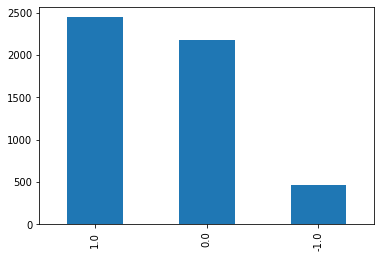

In [18]:
df_positive, df_negative, df_neutral = display_and_plot_all_sentiments(df, "pol", 1)

# Overall Sentiment Analysis Using VADER - ALL COMMENTS

https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

VADER (Valence Aware Dictionary and sEntiment Reasoner) 

In [19]:

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [0]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence).get("compound")
    return score

In [0]:
# Get the vader polarity score of the Comment text coming from the dataframe above.  
# This will be a float within the range [-1.0, 1.0]
vader_pol = get_all_vader_polarities(df) 

In [0]:
df["vader_pol"] = vader_pol
df["vader_pol_abs"] = vader_pol

In [23]:
df.sort_values(by=['vader_pol_abs'],ascending=True).head()

,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs
4969,mercedes e class,Mercedes-Benz,insane 😍,0.0,mercedes e class,5970,"[insane, 😍]","[insane, 😍]","[insane, 😍]","insane, 😍",insane 😍,Insane 😍,-1.0,-1.0,-1.0
2939,mercedes c class,High Peak Autos,e350cdi one want 😂 .. hate diesel !!,5.0,mercedes c class,3940,"[the, e350cdi, is, the, one, you, want, 😂, .., and, i, hate, diesels, !!]","[e350cdi, one, want, 😂, .., hate, diesels, !!]","[e350cdi, one, want, 😂, .., hate, diesel, !!]","e350cdi, one, want, 😂, .., hate, diesel, !!",e350cdi one want 😂 .. hate diesel !!,The E350cdi is the one you want 😂 .. and I hate diesels !!,-1.0,-1.0,-1.0
1207,mercedes a class,YOUCAR,nosotros los pobres toca conformarnos con verlos por youtube :'(,0.0,mercedes a class,2208,"[nosotros, los, pobres, toca, conformarnos, con, verlos, por, youtube, :'(]","[nosotros, los, pobres, toca, conformarnos, con, verlos, por, youtube, :'(]","[nosotros, los, pobres, toca, conformarnos, con, verlos, por, youtube, :'(]","nosotros, los, pobres, toca, conformarnos, con, verlos, por, youtube, :'(",nosotros los pobres toca conformarnos con verlos por youtube :'(,Nosotros los pobres toca conformarnos con verlos por YouTube :'(,-1.0,-1.0,-1.0
3526,mercedes e class,Mercedes-Benz,mahavir branch india (state : telangana ) worst .,0.0,mercedes e class,4527,"[your, mahavir, branch, in, india, (state, :, telangana, ), is, the, worst, .]","[mahavir, branch, india, (state, :, telangana, ), worst, .]","[mahavir, branch, india, (state, :, telangana, ), worst, .]","mahavir, branch, india, (state, :, telangana, ), worst, .",mahavir branch india (state : telangana ) worst .,Your mahavir branch in India (state : Telangana ) is the worst .,-1.0,-1.0,-1.0
823,mercedes a class,TheStraightPipes,want hatchback! :'(,30.0,mercedes a class,1824,"[i, want, the, hatchback!, :'(]","[want, hatchback!, :'(]","[want, hatchback!, :'(]","want, hatchback!, :'(",want hatchback! :'(,I want the hatchback! :'(,-1.0,-1.0,-1.0


https://github.com/cjhutto/vaderSentiment#about-the-scoring: 

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)

negative sentiment: compound score <= -0.05

In [0]:
df['vader_pol'][(df.vader_pol > -0.05) & (df.vader_pol < 0.05)]= 0
df['vader_pol'][df.vader_pol >= 0.05]= 1
df['vader_pol'][df.vader_pol <= -0.05]= -1

In [25]:
df_a = df[df["Type"]== "mercedes a class"]
a_pol = df[df["Type"]== "mercedes a class"]["vader_pol"].value_counts()
a_pol.rename(columns={'vader_pol':'A-Class'}, inplace=True)

 0.0    719
 1.0    716
-1.0    150
dtype: int64

In [26]:
df_c = df[df["Type"]== "mercedes c class"]
c_pol = df[df["Type"]== "mercedes c class"]["vader_pol"].value_counts()
c_pol.rename(columns={'vader_pol':'C-Class'}, inplace=True)

 1.0    787
 0.0    741
-1.0    142
dtype: int64

In [27]:
df_e = df[df["Type"]== "mercedes e class"]
e_pol = df[df["Type"]== "mercedes e class"]["vader_pol"].value_counts()
e_pol.rename(columns={'vader_pol':'E-Class'}, inplace=True)

 1.0    893
 0.0    803
-1.0    141
dtype: int64

In [28]:
print("Average Polarity of E-Class is: ", round(df[df["Type"]== "mercedes e class"]["vader_pol_abs"].mean(),2))

Average Polarity of E-Class is:  0.21


In [29]:
print("Average Polarity of A-Class is: ", round(df[df["Type"]== "mercedes a class"]["vader_pol_abs"].mean(),2))

Average Polarity of A-Class is:  0.17


In [30]:
print("Average Polarity of C-Class is: ", round(df[df["Type"]== "mercedes c class"]["vader_pol_abs"].mean(),2))

Average Polarity of C-Class is:  0.19


In [31]:
combined_pol = pd.concat([a_pol, c_pol, e_pol], axis=1)
combined_pol.rename(index={0:'Neutral',1:'Positive', -1:'Negative'}, 
                 inplace=True)
combined_pol

,0,1,2
Negative,150,142,141
Neutral,719,741,803
Positive,716,787,893




POSITIVE comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs
2,mercedes a class,carwow,sure exterior design interior another planet compare ret market,297.0,mercedes a class,1003,"[not, sure, about, exterior, design, but, interior, is, on, another, planet, compare, to, the, ret, of, the, market, in, its, class]","[sure, exterior, design, interior, another, planet, compare, ret, market]","[sure, exterior, design, interior, another, planet, compare, ret, market]","sure, exterior, design, interior, another, planet, compare, ret, market",sure exterior design interior another planet compare ret market,Not sure about exterior design but interior is on another planet compare to the ret of the market in its class,1.0,1.0,0.5




NEGATIVE comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs
1,mercedes a class,carwow,"front: love it, back: hate it, interior: take money",452.0,mercedes a class,1002,"[front:, love, it,, back:, hate, it,, interior:, take, my, money, mercedes]","[front:, love, it,, back:, hate, it,, interior:, take, money]","[front:, love, it,, back:, hate, it,, interior:, take, money]","front:, love, it,, back:, hate, it,, interior:, take, money","front: love it, back: hate it, interior: take money","Front: love it, back: hate it, interior: take my money mercedes",-1.0,-1.0,-0.1




NEUTRAL comments:


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs
0,mercedes a class,carwow,forget refer friend could earn £50 amazon gift card!,216.0,mercedes a class,1001,"[do, not, forget, to, refer, a, friend, to, carwow, and, you, could, earn, a, £50, amazon, gift, card!]","[forget, refer, friend, could, earn, £50, amazon, gift, card!]","[forget, refer, friend, could, earn, £50, amazon, gift, card!]","forget, refer, friend, could, earn, £50, amazon, gift, card!",forget refer friend could earn £50 amazon gift card!,Do not forget to refer a friend to carwow and you could earn a £50 Amazon gift card!,0.0,0.0,0.0




Plot of all Sentiments:
 1.0    2396
 0.0    2263
-1.0     433
Name: vader_pol, dtype: int64


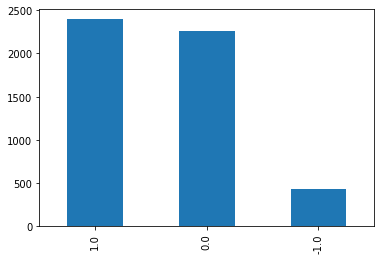

In [32]:
df_positive, df_negative, df_neutral = display_and_plot_all_sentiments(df, "vader_pol", 1)

###The top 5 highest **positive** comments by polarity

In [33]:
df_positive[['Orig_comment','Comment','vader_pol_abs']].sort_values(by=['vader_pol_abs'],ascending=False).head(5)

,Orig_comment,Comment,vader_pol_abs
2206,Perfect! 😎 wish i could own one! 😇🙏,perfect! 😎 wish could one! 😇🙏,1.0
1159,So now Mercedes sytem is like Jarvis <3 this is soo awesome,sytem like jarvis <3 soo awesome,1.0
3482,My father owns it <3,father owns <3,1.0
1239,Hey Mercedes. The best or noting 😚😙😉😀😁,hey mercedes. best noting 😚😙😉😀😁,1.0
1214,The best or nothing. Now a AMG version with 450hp,best nothing. amg version 450hp,1.0


###The bottom 5 most **negative** comments by **polarity**



In [34]:
df_negative[['Orig_comment','Comment','vader_pol_abs']].sort_values(by=['vader_pol_abs'],ascending=True).head(5)

,Orig_comment,Comment,vader_pol_abs
3526,Your mahavir branch in India (state : Telangana ) is the worst .,mahavir branch india (state : telangana ) worst .,-1.0
2799,It is shocking that it lacks keyless Go,shocking lack keyless go,-1.0
2084,Boring car with a boring interior.,boring boring interior.,-1.0
2049,It is boring even in orange,boring even orange,-1.0
293,a lot of awful things to say there,lot awful thing say,-1.0


## Word Cloud Analysis

A Word Cloud is an excellent option to help visually interpret text and is useful in quickly gaining insight into the most prominent items in the text, by visualizing the word frequency in the text as a weighted list. 


In [0]:
def word_cloud(df, col_name, image='undefined', size=13): 
  text = df[col_name].values 

  comment_words = ' '
  stopwords = set(STOPWORDS) 
  #add custom stopwords
  stopwords = stopwords.union({'class', 'mercedes', 'car'})
  #add all of the youtube Channel names, is they exist in this df
  if 'Channel' in df.columns:
    stopwords = stopwords.union(df["Channel"].unique())

  # iterate through the csv file 
  for val in df[col_name]: 
        
      # typecaste each val to string 
      val = str(val) 

      # split the value 
      tokens = val.split() 
        
      # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
            
      for words in tokens: 
          comment_words = comment_words + words + ' '
          
  if (image != 'undefined'):
    thumb_mask = np.array(Image.open(image))
  else:
      thumb_mask = None

  wc = WordCloud(background_color="white", max_words=2000, mask=thumb_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

  # generate word cloud
  wc.generate(str(comment_words))

  #plot
  fig = plt.figure(figsize=(size, size))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()

###By class: Mercedes A Class, Mercedes C Class, Mercedes E Class

Mercedes A Class positive Sentiment


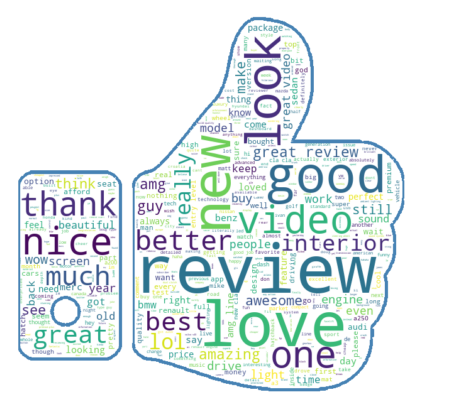

Mercedes C Class positive Sentiment


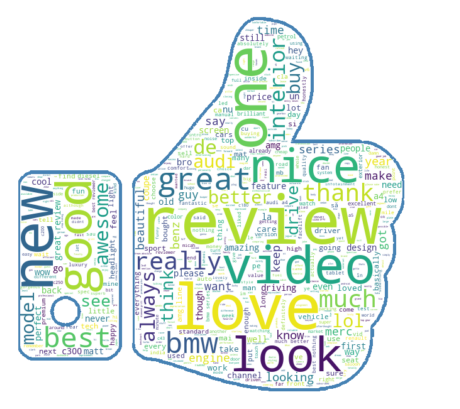

Mercedes E Class positive Sentiment


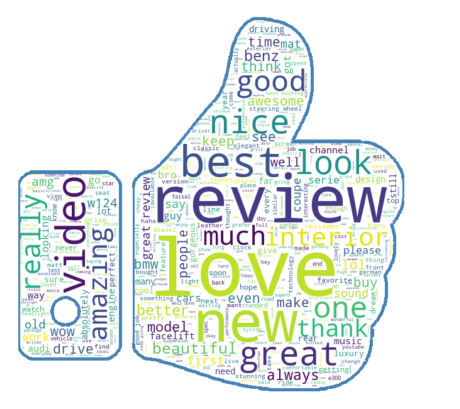

In [36]:
#mercedes a: positive sentiment
print("Mercedes A Class positive Sentiment")
word_cloud(df_a[df.vader_pol == 1], "Comment", "thumbs.jpg", 8)

print("Mercedes C Class positive Sentiment")
#mercedes c: positive sentiment
word_cloud(df_c[df.vader_pol == 1], "Comment", "thumbs.jpg", 8)

print("Mercedes E Class positive Sentiment")
#mercedes e: positive sentiment
word_cloud(df_e[df.vader_pol == 1], "Comment", "thumbs.jpg", 8)

###For all data

In [0]:
df_pos = df[df["vader_pol"] == 1]
df_neg = df[df["vader_pol"] == -1]



In [0]:
brown_news_tagged = brown.tagged_sents(categories='news', tagset='universal')
brown_news_words = brown.tagged_words(categories='news',  tagset='universal')
brown_train = brown_news_tagged[100:]
brown_test = brown_news_tagged[:100]

regexp_tagger = RegexpTagger(
     [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
      (r'(The|the|A|a|An|an)$', 'DET'),   # articles
      (r'.*able$', 'ADJ'),                # adjectives
      (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
      (r'.*ly$', 'ADV'),                  # adverbs
      (r'.*s$', 'NOUN'),                  # plural nouns
      (r'.*ing$', 'VERB'),                # gerunds
      (r'.*ed$', 'VERB'),                 # past tense verbs
      (r'.*', 'NOUN')                     # nouns (default)
])

affix_tagger = AffixTagger(brown_train, backoff=regexp_tagger)
unigram_tagger = UnigramTagger(brown_train, backoff = affix_tagger)
bigram_tagger = NgramTagger(2, brown_train, backoff = unigram_tagger)
bigram_tagger.evaluate(brown_test)

def tag_corpus(text):
    try:
        tags = bigram_tagger.tag(text)
        #tags.append(bigram_tagger.tag(corpus_text))
        
    except Exception as e:
        print(str(e))
    return tags


#### Create a function to identify Adjectives, Adverbs and Nouns to understand them on a Cloud Word analysis

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def adj_filter(tags):
    adj_list = []
    for word,tag in tags:
        if tag == 'ADJ' or tag == 'ADV':
            adj_list.append(word)
    return adj_list

In [0]:
def noun_filter(tags):
    noun_list = []
    for word,tag in tags:
        if tag == 'NOUN':
            noun_list.append(word)
    return noun_list

### Word Clouds for positive comments

In [0]:
def add_token_tag_noun_info(df):
  df["tokens"] = df["Comment"].apply(nltk.word_tokenize, 0)
  df["tags"] = df.tokens.apply(tag_corpus, 0)
  df["noun_test"] = df.tags.apply(noun_filter, 0)
  df['noun_string'] = df.noun_test.apply(lambda x: ' '.join([str(i) for i in x]))

  return df

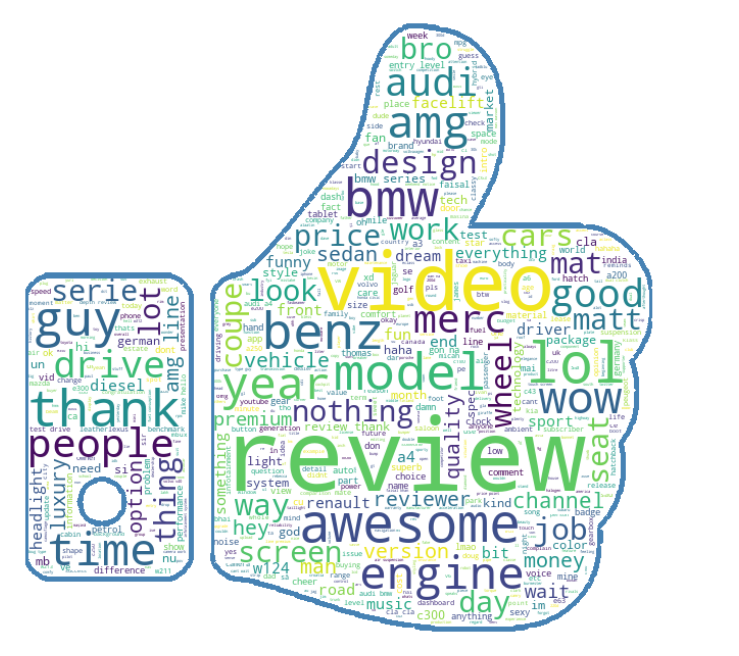

In [43]:
df_pos = add_token_tag_noun_info(df_pos)
word_cloud(df_pos, "noun_string", "thumbs.jpg")

In [44]:
df_pos.head(1)


,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs,tokens,tags,noun_test,noun_string
2,mercedes a class,carwow,sure exterior design interior another planet compare ret market,297.0,mercedes a class,1003,"[not, sure, about, exterior, design, but, interior, is, on, another, planet, compare, to, the, ret, of, the, market, in, its, class]","[sure, exterior, design, interior, another, planet, compare, ret, market]","[sure, exterior, design, interior, another, planet, compare, ret, market]","sure, exterior, design, interior, another, planet, compare, ret, market",sure exterior design interior another planet compare ret market,Not sure about exterior design but interior is on another planet compare to the ret of the market in its class,1.0,1.0,0.5,"[sure, exterior, design, interior, another, planet, compare, ret, market]","[(sure, ADJ), (exterior, ADJ), (design, NOUN), (interior, ADJ), (another, DET), (planet, NOUN), (compare, VERB), (ret, NOUN), (market, NOUN)]","[design, planet, ret, market]",design planet ret market


###Display the Word cloud for the Negative Sentiment Comments

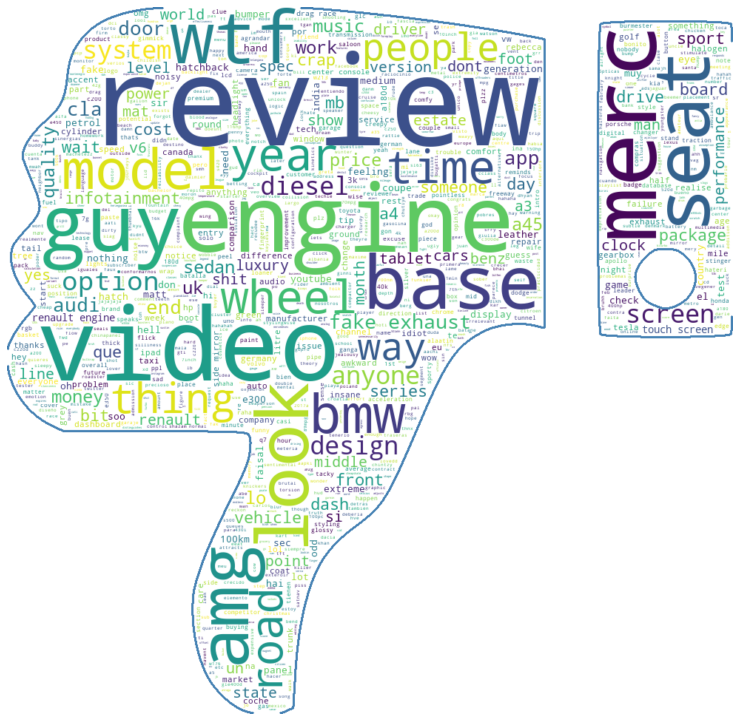

In [45]:
df_neg = add_token_tag_noun_info(df_neg)
word_cloud(df_neg, "noun_string", "thumbs_down.jpg")

# Most Popular Comments by Amount of Likes

In [46]:
#Show top10 most popular comments
most_pop_comments = df.sort_values(by = ['Likes'], ascending = False).head(10)
most_pop_comments

,Query,Channel,Comment,Likes,Type,Index,com_token,com_remv,com_lemma,com_tok_str,com_full,Orig_comment,pol,vader_pol,vader_pol_abs
100,mercedes a class,Doug DeMuro,"fyi, giraffe weighs like 2,800 pound male (1270kg), want one sit you.",4041.0,mercedes a class,1101,"[fyi,, a, giraffe, weighs, like, 2,800, pounds, for, a, male, (1270kg),, so, you, do, not, want, one, to, sit, on, you.]","[fyi,, giraffe, weighs, like, 2,800, pounds, male, (1270kg),, want, one, sit, you.]","[fyi,, giraffe, weighs, like, 2,800, pound, male, (1270kg),, want, one, sit, you.]","fyi,, giraffe, weighs, like, 2,800, pound, male, (1270kg),, want, one, sit, you.","fyi, giraffe weighs like 2,800 pound male (1270kg), want one sit you.","FYI, a giraffe weighs like 2,800 pounds for a male (1270kg), so you do not want one to sit on you.",0.0,0.0,0.00
101,mercedes a class,Doug DeMuro,"police: look phone driving, get ticket lose points. manufacturers: touch pad 18"" touch screen.",2320.0,mercedes a class,1102,"[police:, if, you, look, at, your, phone, while, driving,, you, get, a, ticket, and, lose, points., car, manufacturers:, here, is, a, touch, pad, and, 18"", touch, screen.]","[police:, look, phone, driving,, get, ticket, lose, points., manufacturers:, touch, pad, 18"", touch, screen.]","[police:, look, phone, driving,, get, ticket, lose, points., manufacturers:, touch, pad, 18"", touch, screen.]","police:, look, phone, driving,, get, ticket, lose, points., manufacturers:, touch, pad, 18"", touch, screen.","police: look phone driving, get ticket lose points. manufacturers: touch pad 18"" touch screen.","Police: If you look at your phone while driving, you get a ticket and lose points.\nCar manufacturers: Here is a touch pad and 18"" touch screen.",0.0,0.0,0.00
106,mercedes a class,Doug DeMuro,doug type guy dress better cheaper cars.,2160.0,mercedes a class,1107,"[doug, is, the, type, of, guy, who, dresses, up, better, for, cheaper, cars.]","[doug, type, guy, dresses, better, cheaper, cars.]","[doug, type, guy, dress, better, cheaper, cars.]","doug, type, guy, dress, better, cheaper, cars.",doug type guy dress better cheaper cars.,Doug is the type of guy who dresses up better for cheaper cars.,1.0,1.0,0.50
5,mercedes a class,carwow,"it’s bit like, “honey, shrunk s-class”.",1966.0,mercedes a class,1006,"[it’s, a, bit, like,, “honey,, i, shrunk, the, s-class”.]","[it’s, bit, like,, “honey,, shrunk, s-class”.]","[it’s, bit, like,, “honey,, shrunk, s-class”.]","it’s, bit, like,, “honey,, shrunk, s-class”.","it’s bit like, “honey, shrunk s-class”.","It’s a bit like, “Honey, I Shrunk The S-Class”.",0.0,0.0,0.00
159,mercedes a class,Doug DeMuro,km/h definitely better unit measurement,1654.0,mercedes a class,1160,"[km/h, is, definitely, a, better, unit, of, measurement]","[km/h, definitely, better, unit, measurement]","[km/h, definitely, better, unit, measurement]","km/h, definitely, better, unit, measurement",km/h definitely better unit measurement,km/h is definitely a better unit of measurement,1.0,1.0,0.50
3747,mercedes e class,carwow,dougscore?,1594.0,mercedes e class,4748,"[so, what, is, the, dougscore?]",[dougscore?],[dougscore?],dougscore?,dougscore?,So what is the dougscore?,0.0,0.0,0.00
2523,mercedes c class,Throttle House,watching this.. barley afford gas corolla,1544.0,mercedes c class,3524,"[why, am, i, watching, this.., i, can, barley, afford, to, gas, up, my, corolla]","[watching, this.., barley, afford, gas, corolla]","[watching, this.., barley, afford, gas, corolla]","watching, this.., barley, afford, gas, corolla",watching this.. barley afford gas corolla,Why am i watching this.. i can barley afford to gas up my corolla,0.0,0.0,0.00
1589,mercedes c class,carwow,"thanos : defeat me. avenger : know can, *mat enters carrying stick truth*",1531.0,mercedes c class,2590,"[thanos, :, you, can, not, defeat, me., avengers, :, we, know, but, he, can,, *mat, enters, carrying, his, stick, of, truth*]","[thanos, :, defeat, me., avengers, :, know, can,, *mat, ente

In [47]:
average_sent_pop_comment = np.mean(most_pop_comments["vader_pol_abs"])
average_sent_pop_comment

0.10500000000000001

# Feature Extraction + Sentiment Analysis on Consequent Subset of Data

In [0]:
import shutil

if os.path.exists('yourcorpusfolder'):
    #if the dir exists, delete it 
    shutil.rmtree('yourcorpusfolder')

# then (re)create it    
os.makedirs('yourcorpusfolder')


In [0]:
def CreateCorpusFromDataFrame(corpusfolder,df):
    for index, r in df.iterrows():
        id=r['Index']
        Comment=r['Comment']
        fname= str(id)+'.txt'
        corpusfile= io.open(corpusfolder+'/'+fname,'a',encoding="utf-8")
        corpusfile.write(str(Comment))
        corpusfile.close()

CreateCorpusFromDataFrame('yourcorpusfolder/',df)

In [0]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
my_corpus=CategorizedPlaintextCorpusReader('yourcorpusfolder/', r'.*', cat_pattern=r'(.*)_.*') 

In [0]:
corpus = my_corpus

In [0]:
def get_list_tokens_nltk(corpus, file_name):
    string = get_raw_text(corpus,file_name)
    return get_list_tokens_string(string)
def get_list_tokens_string(string):
    list_words = re.split(r'\W+',string)
    return [w.lower() for w in list_words if w.isalpha() and len(w)>1 and w.lower() not in stopwords_english]    
def get_raw_text(corpus,file_name):
    string = corpus.raw(fileids=file_name)
    return string

stopwords_english = nltk.corpus.stopwords.words('english')

In [0]:
def create_inverted_index(list_document_ids):
  start_time = time.time()

  print ("List of documents ids\n\t", list_document_ids[:5])
  print ("")

  ## 1) Create a inverted index: dictionary with word as key and list of documents where it occurs in sorted order as value
  inverted_index = {}

  ## 2)Loop through the dataset, to get the entire text from  each file
  for (document_index, file_name) in enumerate(list_document_ids):
      
      ##3) Parse the string to get individual words    
      list_words = get_list_tokens_nltk(corpus, file_name)

      ## 4) Update the dictionary with the words in the document and the related document_id
      for w in set(list_words):
          if inverted_index.get(w,0) == 0: # Check if w is not in the vocabulary
              inverted_index[w]=[]
            
          inverted_index[w].append(document_index)

  print ("Inverted Index has been prepared and it took:")
  print ("\n\t", time.time() - start_time, "seconds")

  print ("")
  print ("Example of List of words for document\n\t", document_index, list_words[:1])
  print ("")

  print ("")
  print ("Example of entry for word nightmare\n\t", inverted_index['nightmare'])
  print ("")

  return inverted_index

In [0]:
def query_string_search(query, op, list_document_ids, inverted_index):  

  start_time = time.time()
  query_list = get_list_tokens_string(query)
  result_file_indices= []

  if op=='OR' or op=='or': # OR query
      for q in query_list:
          print ("\nRetrieving documents including", q)
          if inverted_index.get(q.lower(), 0)!=0: # If there is any document including q
              print ("\tDocuments including", q, ":", inverted_index[q.lower()])
              print ("")
              result_file_indices.extend(inverted_index[q.lower()])
              
  else: # AND query
      file_indices=range(len(list_document_ids))
      for q in query_list:
          print ("\nRetrieving documents including", q)
          if inverted_index.get(q.lower(), 0)==0: # Check if the term is included in the inverted index
              print ("Term", q, "does not appear in the corpus")
              print ("")
              file_indices=[] #Return empty document list       
              break
          else:
              temp_list=[]
              query_file_indices = inverted_index[q.lower()]
              print ("")
              index_f=0
              index_q=0
              # Go over the document list and the result list (documents including q)
              print ("\tDocuments including previous query terms:", file_indices)
              print ("")
              print ("\tDocuments including", q, ":", query_file_indices)
              print ("")
              while index_f < len(file_indices) and index_q < len(query_file_indices):
                  if file_indices[index_f] == query_file_indices[index_q]:
                      # Add to the final result list only those documents included in both lists
                      temp_list.append(query_file_indices[index_q])
                      index_f+=1
                      index_q+=1
                  elif file_indices[index_f] < query_file_indices[index_q]:
                      index_f+=1
                  else:
                      index_q+=1
              file_indices=[]
              file_indices.extend(temp_list)
              print ("")
              print ("")
      result_file_indices.extend(file_indices)

  if(len(result_file_indices)==0):
      print ("Sorry No matches found")
  else:
      print ("Number of search results : " , len(result_file_indices))
      print ("Results:")
      for index in result_file_indices:
          print (get_raw_text(corpus, list_document_ids[index]))
          print ("\n")

  return result_file_indices

In [55]:
 # Get the list if documents ids in the corpus
list_document_ids =  corpus.fileids()

inverted_index = create_inverted_index(list_document_ids)

List of documents ids
	 ['1001.txt', '1002.txt', '1003.txt', '1004.txt', '1005.txt']

Inverted Index has been prepared and it took:

	 0.40018129348754883 seconds

Example of List of words for document
	 5091 ['ugly']


Example of entry for word nightmare
	 [141, 973, 3960]



In [56]:
query = input("Enter your query string : ")
op = input("Enter the operator, (AND/OR) Default is AND: ")

result_file_indices = query_string_search(query, op, list_document_ids, inverted_index)


Enter your query string : engine bumper wheels
Enter the operator, (AND/OR) Default is AND: or

Retrieving documents including engine
	Documents including engine : [67, 71, 122, 151, 158, 161, 190, 212, 216, 259, 344, 379, 384, 487, 488, 629, 732, 753, 946, 964, 979, 983, 990, 1003, 1040, 1045, 1059, 1065, 1082, 1085, 1099, 1100, 1109, 1113, 1125, 1132, 1140, 1265, 1277, 1282, 1290, 1351, 1376, 1498, 1514, 1560, 1921, 1943, 1987, 1994, 1996, 1999, 2011, 2012, 2055, 2062, 2070, 2161, 2190, 2215, 2276, 2295, 2352, 2415, 2455, 2513, 2559, 2895, 2941, 2952, 2958, 2970, 2973, 2985, 2992, 3008, 3041, 3128, 3300, 3391, 3420, 3576, 3601, 3613, 3829, 3885, 3890, 3894, 3916, 3984, 3985, 4175, 4234, 4267, 4269, 4389, 4391, 4523, 4526, 4582, 4642, 4657, 4699, 4749, 4828, 4829, 4834, 5068]


Retrieving documents including bumper
	Documents including bumper : [418, 473, 1265, 2019, 2232, 2714, 3074, 3095, 3159, 3399, 3431, 3603]


Retrieving documents including wheels
	Documents including wheels : [

In [0]:
#Create new dataframe only including comments based on query
x=[]
for index in result_file_indices:
    x.append(get_raw_text(corpus, list_document_ids[index]))

In [0]:
df_x = pd.DataFrame(x, columns = ["Comment"]) 

In [0]:
vader_pol=[] # list which will contain the polarity of the comments
for i in df_x.Comment.values:
    try:
        analysis =sentiment_analyzer_scores(i)
        vader_pol.append(analysis)
        
    except:
        vader_pol.append(0)

In [0]:
df_x["vader_pol"] = vader_pol
df_x["vader_pol_abs"] = vader_pol

https://github.com/cjhutto/vaderSentiment#about-the-scoring: 

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)

negative sentiment: compound score <= -0.05

In [0]:
df_x['vader_pol'][(df_x.vader_pol > -0.05) & (df_x.vader_pol < 0.05)]= 0
df_x['vader_pol'][df_x.vader_pol >= 0.05]= 1
df_x['vader_pol'][df_x.vader_pol <= -0.05]= -1

In [62]:
df_x.head()

,Comment,vader_pol,vader_pol_abs
0,renault engine to? like last model a?,1.0,0.4329
1,love even reviewer avoid fact car renault engine them.,1.0,0.4588
2,"car,already check engine light on, new? say lot,crappy expensive fix, hard maintain german car",-1.0,-0.1027
3,like check engine light whole video dash board 😂😂,1.0,0.3612
4,15:15 check engine light,0.0,0.0000




POSITIVE comments:


,Comment,vader_pol,vader_pol_abs
0,renault engine to? like last model a?,1.0,0.4329
1,love even reviewer avoid fact car renault engine them.,1.0,0.4588
3,like check engine light whole video dash board 😂😂,1.0,0.3612
6,"love a220! two 2 days! super comfy, high tech engine strong. btw great review detailed. see ya!",1.0,0.9544
8,got a200 love rorty sound engine make pressing,1.0,0.6369




NEGATIVE comments:


,Comment,vader_pol,vader_pol_abs
2,"car,already check engine light on, new? say lot,crappy expensive fix, hard maintain german car",-1.0,-0.1027
11,wrong car! try a35 amg a45s amg coming couple months. feel 400hp 2 litre engine!,-1.0,-0.5696
16,wish bigger engine option :(,-1.0,-0.0516
25,want stress diesel engine also dacia duster,-1.0,-0.3612
29,need bigger diesel engine made renault :/ sad !,-1.0,-0.6996




NEUTRAL comments:


,Comment,vader_pol,vader_pol_abs
4,15:15 check engine light,0.0,0.0000
5,come factory engine light on.,0.0,0.0000
7,renault engine torsion bar suspension haha badge freak lap regardless.,0.0,0.0258
9,renault engine?!,0.0,0.0000
12,renault engine,0.0,0.0000




Plot of all Sentiments:
 1.0    66
 0.0    37
-1.0    21
Name: vader_pol, dtype: int64


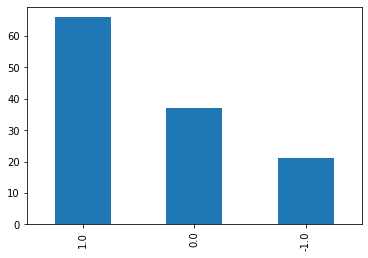

In [63]:
df_x_positive, df_x_negative, df_x_neutral = display_and_plot_all_sentiments(df_x, "vader_pol", 5)

### POS Tagging (adjectives detection)

In [0]:
df["tokens"] = df["Comment"].apply(nltk.word_tokenize, 0)
df_x["tokens"] = df_x["Comment"].apply(nltk.word_tokenize, 0)
df["tags"] = df.tokens.apply(tag_corpus, 0)
df_x["tags"] = df_x.tokens.apply(tag_corpus, 0)
df["adj_test"] = df.tags.apply(adj_filter, 0)
df_x["adj_test"] = df_x.tags.apply(adj_filter, 0)
df['adj_string'] = df.adj_test.apply(lambda x: ' '.join([str(i) for i in x]))
df_x['adj_string'] = df_x.adj_test.apply(lambda x: ' '.join([str(i) for i in x]))

In [65]:
df_x['adj_string'].head(5)

0                                       last
1                                       even
2    already light new crappy expensive hard
3                                light whole
4                                      light
Name: adj_string, dtype: object

###**Adjectives** found in the Comments related to the query search string:

( engine bumper wheels )


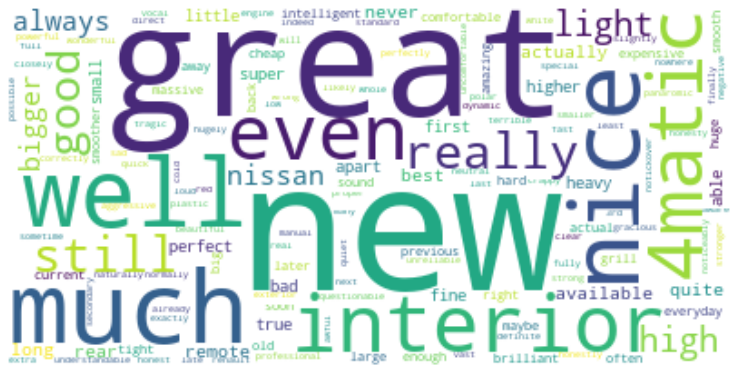

In [66]:
print("(", query, ")")
word_cloud(df_x,"adj_string")

###**Adjectives** found in ALL of the Comments in the dataset:

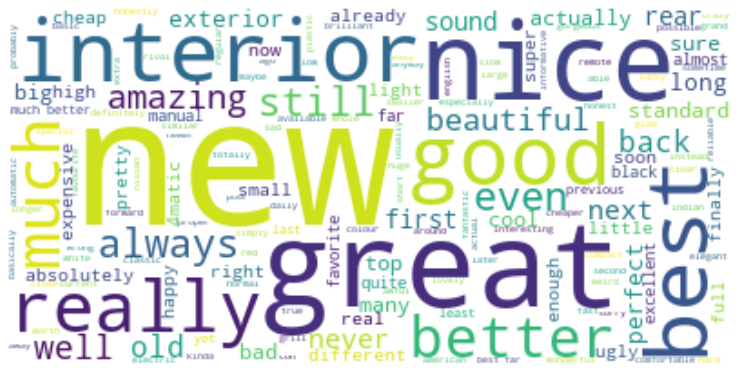

In [67]:
word_cloud(df,"adj_string")

In [68]:
df_x.head()

,Comment,vader_pol,vader_pol_abs,tokens,tags,adj_test,adj_string
0,renault engine to? like last model a?,1.0,0.4329,"[renault, engine, to, ?, like, last, model, a, ?]","[(renault, NOUN), (engine, NOUN), (to, PRT), (?, .), (like, ADP), (last, ADJ), (model, NOUN), (a, DET), (?, .)]",[last],last
1,love even reviewer avoid fact car renault engine them.,1.0,0.4588,"[love, even, reviewer, avoid, fact, car, renault, engine, them, .]","[(love, VERB), (even, ADV), (reviewer, NOUN), (avoid, VERB), (fact, NOUN), (car, NOUN), (renault, NOUN), (engine, NOUN), (them, PRON), (., .)]",[even],even
2,"car,already check engine light on, new? say lot,crappy expensive fix, hard maintain german car",-1.0,-0.1027,"[car, ,, already, check, engine, light, on, ,, new, ?, say, lot, ,, crappy, expensive, fix, ,, hard, maintain, german, car]","[(car, NOUN), (,, .), (already, ADV), (check, NOUN), (engine, NOUN), (light, ADJ), (on, ADP), (,, .), (new, ADJ), (?, .), (say, VERB), (lot, NOUN), (,, .), (crappy, ADJ), (expensive, ADJ), (fix, N...","[already, light, new, crappy, expensive, hard]",already light new crappy expensive hard
3,like check engine light whole video dash board 😂😂,1.0,0.3612,"[like, check, engine, light, whole, video, dash, board, 😂😂]","[(like, ADP), (check, NOUN), (engine, NOUN), (light, ADJ), (whole, ADJ), (video, NOUN), (dash, NOUN), (board, NOUN), (😂😂, NOUN)]","[light, whole]",light whole
4,15:15 check engine light,0.0,0.0000,"[15:15, check, engine, light]","[(15:15, NUM), (check, NOUN), (engine, NOUN), (light, ADJ)]",[light],light
